In [15]:
%matplotlib notebook
import random
import pandas as pd
import numpy as np
import igraph
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import nltk
import csv
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.utils import np_utils
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [16]:
node_information = pd.read_csv('node_information.csv', header=None, names=['ID', 'Year', 'Title', 'Authors', 'Journal', 'Abstract'])
training_set = pd.read_csv('training_set.txt', header=None, names=['Target', 'Source', 'Edge'], delim_whitespace=True)
testing_set = pd.read_csv('testing_set.txt', header=None, names=['Target', 'Source'], delim_whitespace=True)

In [17]:
#more features created using feature generation-2 notebook
train = pd.read_csv('train_complete.csv',header=0)
test = pd.read_csv('test_complete.csv',header=0)
features = ['Title overlap', 'Abstract overlap', 'Temporal difference', 'Common authors', 'Common journal',
            'Cosine similarity', 'Authors in abstract', 'LSA distance', # Semantic features
            'Betweenness centrality', 'Same cluster', 'Page rank', 'Ressource allocation', 'Jaccard coefficient',
            'Adamic Adar', 'Preferential attachment', 'Target_indegree', 'Target_outdegree',
            'Source_indegree', 'Source_outdegree', 'Common_in', 'Common_out' #Topological features
           ]
train = train[features]
test =  test[features]
train_2 = np.array(train)
test_2 = np.array(test)
labels_array = np.array(training_set['Edge'].values)
print(train_2.shape,test_2.shape)

(615512, 21) (32648, 21)


##### Prediction with different classifiers
> [A - SVM](#2a)  
> [B - Random forest](#2b)     
> [D - Extra tree classifier](#2d)    
> [E - Extra gradient boosting](#2e)    
> [F - LightGBM classifier](#2f)    
> [G - Neural network](#2g)  


In [18]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
training_features = min_max_scaler.fit_transform(train)
testing_features = min_max_scaler.transform(test)

In [19]:
%%time
classifier = svm.LinearSVC()
np.mean(cross_val_score(classifier, training_features, labels_array, cv=3, scoring ="f1"))

Wall time: 19.5 s


0.9644355081581378

In [31]:
%%time 
# First Kaggle submission gave a score of 0.95 on kaggle
classifier.fit(training_features, labels_array)
predictions_SVM = list(classifier.predict(testing_features))
predictions_SVM = zip(range(len(testing_set)), predictions_SVM)
test = pd.DataFrame(predictions_SVM)
sub = test.copy()
sub['id']=sub.index
sub['category'] = sub[1]
sub = sub[['id', 'category']]
#sub.to_csv('sub/sub_SVM.csv', index=False)

Wall time: 24.3 s


In [20]:
print(training_features.shape,testing_features.shape,labels_array.shape)

(615512, 21) (32648, 21) (615512,)


In [21]:
X_train,X_test,y_train,y_test = train_test_split(training_features,labels_array,test_size=0.2)

In [53]:
%%time
model = RandomForestClassifier(n_estimators=100, max_depth=9,random_state=0)
model.fit(X_train, y_train)
f1_score(y_test,model.predict(X_test),average='micro')

Wall time: 3min 30s


0.9745903836624615

In [54]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
xrf = ExtraTreesClassifier(max_features=None, min_samples_leaf= 20, n_estimators = 300, n_jobs= 3)
xrf.fit(X_train, y_train)
pred_xrf = xrf.predict(X_test)
f1_score(y_test,pred_xrf,average='micro')

Wall time: 7min 35s


0.9749396846543139

In [56]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(n_estimators=500, max_depth=6, subsample=0.9,colsample_bytree=0.8)
clf_xgb.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_test,y_test)],eval_metric='logloss',early_stopping_rounds=10,verbose=True)
print(f1_score(y_test,clf_xgb.predict(X_test)))

C:\Users\rkroc\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.46274	validation_1-logloss:0.46256
[1]	validation_0-logloss:0.33345	validation_1-logloss:0.33345
[2]	validation_0-logloss:0.25268	validation_1-logloss:0.25282
[3]	validation_0-logloss:0.19956	validation_1-logloss:0.19977
[4]	validation_0-logloss:0.16286	validation_1-logloss:0.16328
[5]	validation_0-logloss:0.13739	validation_1-logloss:0.13789
[6]	validation_0-logloss:0.11954	validation_1-logloss:0.12021
[7]	validation_0-logloss:0.10625	validation_1-logloss:0.10702
[8]	validation_0-logloss:0.09662	validation_1-logloss:0.09749
[9]	validation_0-logloss:0.08961	validation_1-logloss:0.09077
[10]	validation_0-logloss:0.08453	validation_1-logloss:0.08577
[11]	validation_0-logloss:0.08082	validation_1-logloss:0.08215
[12]	validation_0-logloss:0.07760	validation_1-logloss:0.07910
[13]	validation_0-logloss:0.07541	validation_1-logloss:0.07701
[14]	validation_0-logloss:0.07360	validation_1-logloss:0.07534
[15]	validation_0-logloss:0.07227	validation_1-logloss:0.07417
[1

In [ ]:
with open("predictions_xgb.csv","w",newline="") as pred1:
    fieldnames = ['id', 'category']
    csv_out = csv.writer(pred1)
    csv_out.writerow(fieldnames)
    for row in predictions_xgb:
        csv_out.writerow(row)

In [61]:
%%time
import lightgbm as lgb
clf_lgbm = lgb.LGBMClassifier(n_estimators=1000, max_depth=4, reg_lambda=1., subsample=0.9, colsample_bytree=0.8)
clf_lgbm.fit(X_train, y_train)#other
print(f1_score(y_test,clf_lgbm.predict(X_test)))

C:\Users\rkroc\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


0.9792435112496715
Wall time: 27.1 s


In [27]:
Y_train = np.array([y_train,(1-y_train)]).T
Y_test = np.array([y_test,(1-y_test)]).T

In [28]:
model = Sequential()
model.add(Dense(16, input_shape=(21,)))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
# choose a optimizer for our neural network
rms = RMSprop()
model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
from keras import callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss',patience=2,verbose=0, mode='auto')
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                352       
                                                                 
 activation_12 (Activation)  (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                544       
                                                                 
 activation_13 (Activation)  (None, 32)                0         
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 activation_14 (Activation)  (None, 64)               

In [30]:
history = model.fit(X_train, Y_train,batch_size=256, epochs=10, verbose=2,validation_data=(X_test, Y_test), callbacks = [early_stopping])
score =   model.evaluate(X_test, Y_test, verbose=2)
score

Epoch 1/10
1924/1924 - 35s - loss: 0.1168 - accuracy: 0.9631 - val_loss: 0.0960 - val_accuracy: 0.9684 - 35s/epoch - 18ms/step
Epoch 2/10
1924/1924 - 43s - loss: 0.1034 - accuracy: 0.9671 - val_loss: 0.0898 - val_accuracy: 0.9706 - 43s/epoch - 23ms/step
Epoch 3/10
1924/1924 - 44s - loss: 0.0987 - accuracy: 0.9688 - val_loss: 0.0882 - val_accuracy: 0.9714 - 44s/epoch - 23ms/step
Epoch 4/10
1924/1924 - 42s - loss: 0.0958 - accuracy: 0.9694 - val_loss: 0.0867 - val_accuracy: 0.9719 - 42s/epoch - 22ms/step
Epoch 5/10
1924/1924 - 39s - loss: 0.0940 - accuracy: 0.9700 - val_loss: 0.0882 - val_accuracy: 0.9709 - 39s/epoch - 20ms/step
Epoch 6/10
1924/1924 - 36s - loss: 0.0927 - accuracy: 0.9707 - val_loss: 0.0843 - val_accuracy: 0.9727 - 36s/epoch - 19ms/step
Epoch 7/10
1924/1924 - 37s - loss: 0.0919 - accuracy: 0.9710 - val_loss: 0.0839 - val_accuracy: 0.9727 - 37s/epoch - 19ms/step
Epoch 8/10
1924/1924 - 36s - loss: 0.0910 - accuracy: 0.9711 - val_loss: 0.0824 - val_accuracy: 0.9731 - 36s/ep

[0.08466251194477081, 0.9714142084121704]

<IPython.core.display.Javascript object>


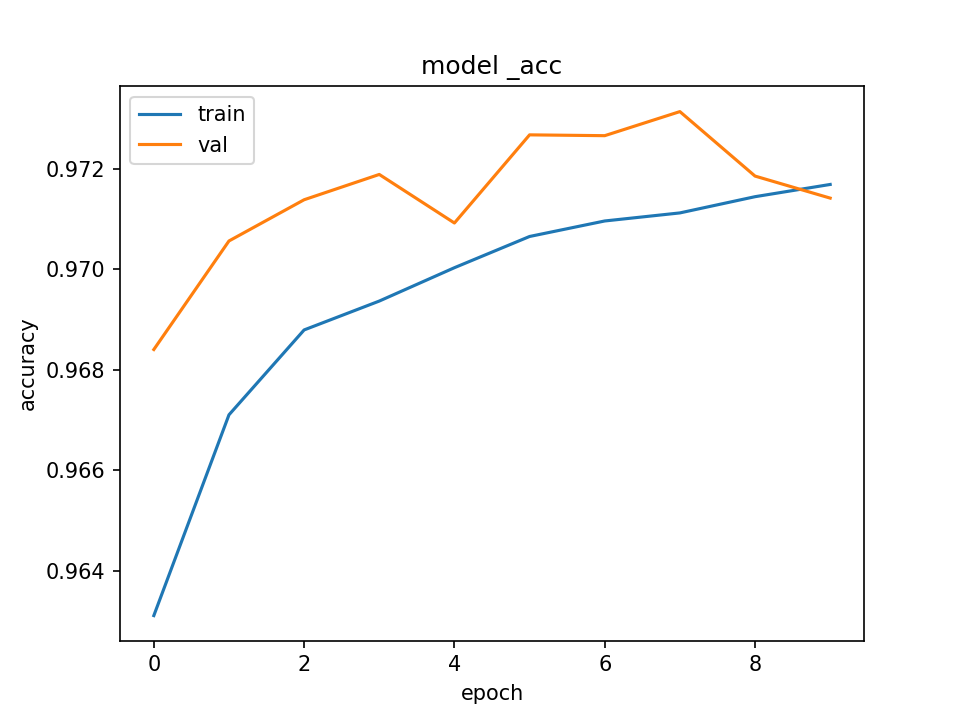

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model _acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


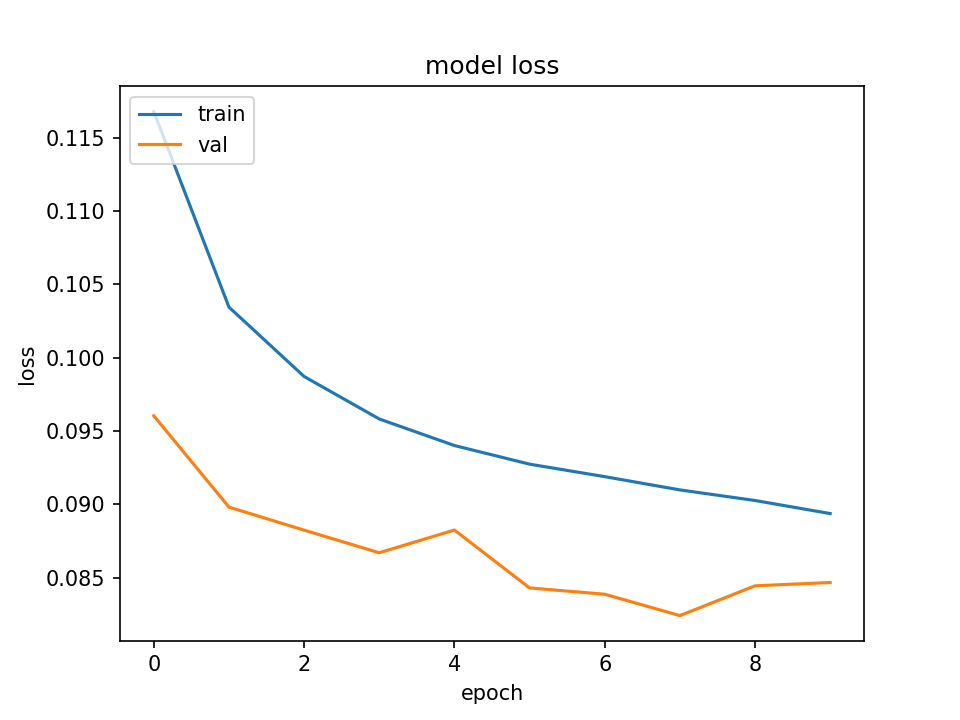

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()